# Automated ML (AutoML) with Azure ML

**Automated machine learning**, also referred to as automated ML or AutoML, is the **process of automating the time consuming, iterative tasks of machine learning model development**.<br><br>
It allows data scientists, analysts, and developers to build ML models with high scale, efficiency, and productivity all while sustaining model quality. **Automated ML is based on a breakthrough from our Microsoft Research division.**

Traditional machine learning model development is resource-intensive, requiring significant domain knowledge and time to produce and compare dozens of models. **With automated machine learning, you'll accelerate the time it takes to get production-ready ML models with great ease and efficiency.**

<img src="https://docs.microsoft.com/ko-kr/azure/machine-learning/service/media/how-to-automated-ml/automl-concept-diagram2.png">

### AutoML Documentation:
* https://docs.microsoft.com/en-us/azure/machine-learning/concept-automated-ml
* https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train    

## Titanic dataset

<img src="https://kwmp.ca/wp-content/uploads/2018/04/titanic-the-musical-1024x538.jpg">

Notebook Python Azure ML pour la modélisation automatique (AUTOML) de la survie des passagers du Titanic.
<br><br>
https://www.kaggle.com/c/titanic
<br><br>
Données : 
https://www.kaggle.com/c/titanic/data

 ## Description des variables :
 - PassengerId: and id given to each traveler on the boat
 - Pclass: the passenger class. It has three possible values: 1,2,3 (first, second and third class)
 - The Name of the passeger
 - The Sex
 - The Age
 - SibSp: number of siblings and spouses traveling with the passenger
 - Parch: number of parents and children traveling with the passenger
 - The ticket number
 - The ticket Fare
 - The cabin number
 - The embarkation. This describe three possible areas of the Titanic from which the people embark. Three possible values S,C,Q

> https://www.kaggle.com/c/titanic

### 0. Paramétrage

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print('Today =', now)

Today = 2020-09-30 15:28:35.616077


In [3]:
#!pip install --upgrade azureml-sdk
#!pip install --upgrade azureml-sdk[automl,notebooks,explain,contrib,services,tensorboard]

In [4]:
import azureml.core
print("Version Azure ML Service :", azureml.core.VERSION)

Version Azure ML Service : 1.8.0


In [5]:
import os

subscription_id = os.environ.get("SUBSCRIPTION_ID", "TOBEREPLACED")
resource_group = os.environ.get("RESOURCE_GROUP", "titanicworkspaceRG")
workspace_name = os.environ.get("WORKSPACE_NAME", "Titanicworkspace")

In [6]:
from azureml.core import Workspace

try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print("Le workspace Azure ML service a été trouvé : OK")
except:
   print("Le workspace Azure ML service n'a pas été trouvé")

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code CL5W2MFFD to authenticate.
Interactive authentication successfully completed.
Le workspace Azure ML service a été trouvé : OK


In [7]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

import logging
import os
import random

## 1. Chargement des données

In [8]:
import azureml.dataprep as dprep

In [9]:
pd.set_option('display.max_columns', None)

titanic_path = "https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv"

print("Retrieving data:")
print(titanic_path)

titanic_df = dprep.read_csv(path=titanic_path, header=dprep.PromoteHeadersMode.GROUPED)

display(titanic_df.head(5))

Retrieving data:
https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


In [10]:
all_columns = dprep.ColumnSelector(term=".*", use_regex=True)

drop_if_all_null = [all_columns, dprep.ColumnRelationship(dprep.ColumnRelationship.ALL)]

useful_columns = [
    "PassengerId", "Survived", "Pclass", "Sex", "Age", "SibSp",
    "Fare", "Embarked"
]

tmp_df = (titanic_df
    .replace_na(columns=all_columns)
    .drop_nulls(*drop_if_all_null)
    .rename_columns(column_pairs={
        "PassengerId": "PassengerId",
        "Survived": "Survived",
        "Pclass": "Pclass",
        "Sex": "Sex",
        "Age": "Age",
        "SibSp": "SibSp",
        "Fare": "Fare",
        "Embarked": "Embarked",
     })
    .keep_columns(columns=useful_columns))
tmp_df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
0,1,0,3,male,22,1,7.25,S
1,2,1,1,female,38,1,71.2833,C
2,3,1,3,female,26,0,7.925,S
3,4,1,1,female,35,1,53.1,S
4,5,0,3,male,35,0,8.05,S


In [11]:
decimal_type = dprep.TypeConverter(data_type=dprep.FieldType.DECIMAL)
profile = tmp_df.set_column_types(type_conversions={
    "Age": decimal_type,
    "Fare": decimal_type
}).get_profile()

In [12]:
profile

,Type,Min,Max,Count,Missing Count,Not Missing Count,Percent Missing,Error Count,Empty Count,Unique Values,0.1% Quantile (est.),1% Quantile (est.),5% Quantile (est.),25% Quantile (est.),50% Quantile (est.),75% Quantile (est.),95% Quantile (est.),99% Quantile (est.),99.9% Quantile (est.),Mean,Standard Deviation,Variance,Skewness,Kurtosis,WhiskerTop,WhiskerBottom
PassengerId,FieldType.STRING,1,99,891.0,0.0,891.0,0.000000,0.0,0.0,891,,,,,,,,,,,,,,,,
Survived,FieldType.STRING,0,1,891.0,0.0,891.0,0.000000,0.0,0.0,2,,,,,,,,,,,,,,,,
Pclass,FieldType.STRING,1,3,891.0,0.0,891.0,0.000000,0.0,0.0,3,,,,,,,,,,,,,,,,
Sex,FieldType.STRING,female,male,891.0,0.0,891.0,0.000000,0.0,0.0,2,,,,,,,,,,,,,,,,
Age,FieldType.DECIMAL,0.42,80,891.0,177.0,714.0,0.198653,0.0,0.0,89,0.4735,13.5111,12.6667,20.28,28,38.2,56.3067,67.44,78.716,29.6991,14.5265,211.019,0.387474,0.159767,65,0.42
SibSp,FieldType.STRING,0,8,891.0,0.0,891.0,0.000000,0.0,0.0,7,,,,,,,,,,,,,,,,
Fare,FieldType.DECIMAL,0,512.329,891.0,0.0,891.0,0.000000,0.0,0.0,248,0,7.54406,7.5156,7.90776,14.456,31.066,112.451,255.394,512.329,32.2042,49.6934,2469.44,4.77121,33.1231,63.3433,0
Embarked,FieldType.STRING,C,S,891.0,2.0,889.0,0.002245,0.0,0.0,4,,,,,,,,,,,,,,,,


In [13]:
url="https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv"
df=pd.read_csv(url, index_col=None, na_values=['NA'])

In [14]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
# Suppression valeurs manquantes
df = df.dropna()

In [16]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [17]:
# Nombre de col et de lignes
df.shape

(183, 12)

In [18]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [19]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [20]:
# Suppression de colonnes
df = df.drop(['Cabin','Parch'],axis=1)

In [21]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,PC 17599,71.2833,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,113803,53.1000,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,17463,51.8625,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,PP 9549,16.7000,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,113783,26.5500,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,248698,13.0000,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,113788,35.5000,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,19950,263.0000,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,PC 17572,76.7292,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,113509,61.9792,C


## 2. Analyses exploratoires

In [22]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,455.366120,0.672131,1.191257,35.674426,0.464481,78.682469
std,247.052476,0.470725,0.515187,15.643866,0.644159,76.347843
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,57.000000
75%,676.000000,1.000000,1.000000,47.500000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,512.329200


In [23]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
PassengerId,1.000000,0.148495,-0.089136,0.030933,-0.083488,0.029740
Survived,0.148495,1.000000,-0.034542,-0.254085,0.106346,0.134241
Pclass,-0.089136,-0.034542,1.000000,-0.306514,-0.103592,-0.315235
Age,0.030933,-0.254085,-0.306514,1.000000,-0.156162,-0.092424
SibSp,-0.083488,0.106346,-0.103592,-0.156162,1.000000,0.286433
Fare,0.029740,0.134241,-0.315235,-0.092424,0.286433,1.000000


## 3. Modélisation AutoML avec Azure ML service

In [24]:
col_target=['Survived']
col_train=['Age','Pclass','Sex','Fare','SibSp','Embarked']
X=df[col_train]
y=df[col_target]

In [25]:
X.describe()

,Age,Pclass,Fare,SibSp
count,183.000000,183.000000,183.000000,183.000000
mean,35.674426,1.191257,78.682469,0.464481
std,15.643866,0.515187,76.347843,0.644159
min,0.920000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,29.700000,0.000000
50%,36.000000,1.000000,57.000000,0.000000
75%,47.500000,1.000000,90.000000,1.000000
max,80.000000,3.000000,512.329200,3.000000


In [26]:
dic = {'male':0,'female':1}
X['Sex']=X['Sex'].apply(lambda x:dic[x])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pan

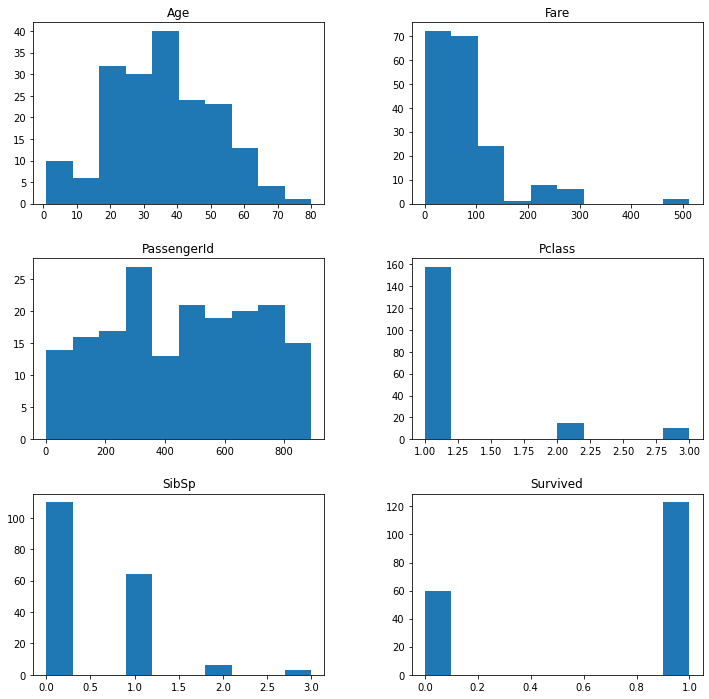

In [27]:
df.hist(bins=10,figsize=(12,12),grid=False);

In [28]:
def tableau (param1, param2):
    df_slice = df[[param1, param2, 'PassengerId']]
    slice_pivot = df_slice.pivot_table(index=[param1], columns=[param2],aggfunc=np.size, fill_value=0)
    
    p_chart = slice_pivot.plot.bar()
    for p in p_chart.patches:
        p_chart.annotate(str(p.get_height()), (p.get_x() * 1.05, p.get_height() * 1.01))
    
    return slice_pivot
    return p_chart

PassengerId       
Pclass             1   2  3
Survived                   
0                 52   3  5
1                106  12  5

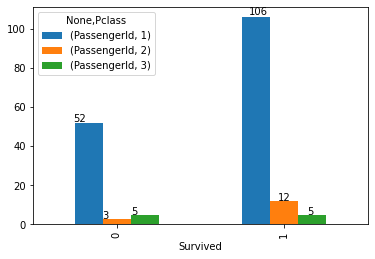

In [29]:
tableau ('Survived','Pclass')

PassengerId     
Sex           female male
Survived                 
0                  6   54
1                 82   41

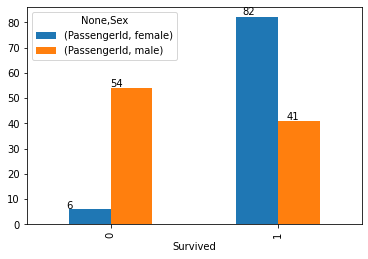

In [30]:
tableau ('Survived','Sex')

PassengerId       
Embarked           C  Q   S
Survived                   
0                 17  1  42
1                 48  1  74

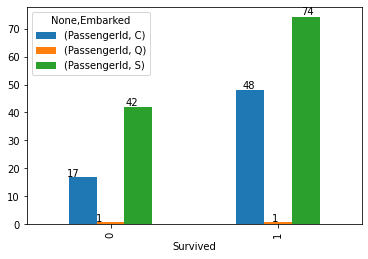

In [31]:
tableau ('Survived','Embarked')

### 3.1 Partitionnement des données

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=10)

In [33]:
print(X.shape)

(183, 6)


In [34]:
print(X_train.shape)

(128, 6)


In [35]:
print(X_test.shape)

(55, 6)


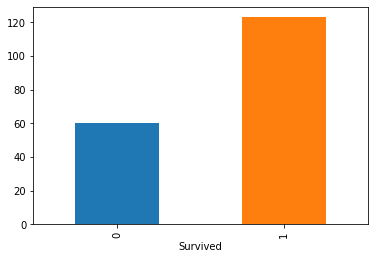

In [36]:
df.groupby('Survived').size().plot(kind='bar')

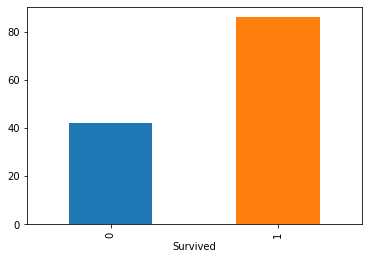

In [37]:
# Sur le Training
y_train.groupby('Survived').size().plot(kind='bar')

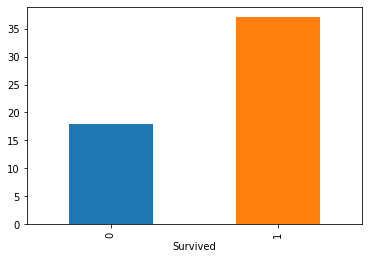

In [38]:
# Sur le test
y_test.groupby('Survived').size().plot(kind='bar')

### 3.2 Connexion workspace Azure ML service

In [39]:
ws = Workspace.from_config()

experiment_name = 'AutoMLTitanicSDK'

project_folder = './sample_projects/automltitanicsdk'

In [40]:
experiment = Experiment(ws, experiment_name)

output = {}
output['Version Azure ML service'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
Version Azure ML service,1.8.0
Workspace Name,Titanicworkspace
Resource Group,titanicworkspaceRG
Location,westeurope
Project Directory,./sample_projects/automltitanicsdk
Experiment Name,AutoMLTitanicSDK


### 3.3 AutoML avec Azure ML service

### Les principes de l'autoML
> https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml

 ### Aide en ligne AutoML avec Azure ML service
> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### Paramétrage AutoML

In [41]:
import logging

automl_settings = {
    "iteration_timeout_minutes" : 5,             # Time out per iteration
    "experiment_timeout_minutes" : 20,           # Time out for the fullprocess
    "iterations" : 20,                           # Max number of iterations
    "primary_metric" : 'AUC_weighted',           # Metric
    "enable_early_stopping" : True,              # Stopping criteria
    "verbosity" : logging.INFO,                  # Logging
    #"enable_voting_ensemble": False,            # No votin model
    #"enable_stack_ensemble": False              # No ensemble model
}

In [42]:
from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(task='classification',
                             debug_log = 'automated_ml_errors.log',
                             path = project_folder,
                             model_explainability=True,
                             X = X_train.values,
                             y = y_train.values.flatten(),
                             X_valid = X_test.values,
                             y_valid = y_test.values.flatten(),
                             **automl_settings)

WARNING - The AutoMLConfig parameters, X and y, will soon be deprecated. Please refer to our documentation for the latest interface: https://aka.ms/AutoMLConfig


> Liste des modèles disponibles : https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### AUTOML

In [44]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_68d7346d-5e57-4610-a182-8e4c2aa1429b

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were 

### Visualisation des itérations depuis Azure ML Studio :

In [45]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoMLTitanicSDK,AutoML_68d7346d-5e57-4610-a182-8e4c2aa1429b,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


### Widget AutoML

In [46]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### 3.4 Liste des résultats autoML

In [47]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AUC_macro,0.86,0.89,0.83,0.87,0.86,0.85,0.89,0.86,0.83,0.87,0.80,0.86,0.88,0.86,0.85,0.89,0.82,0.88,0.91,0.88
AUC_micro,0.88,0.88,0.87,0.87,0.88,0.87,0.90,0.85,0.85,0.88,0.83,0.87,0.87,0.88,0.87,0.89,0.86,0.89,0.92,0.89
AUC_weighted,0.86,0.89,0.83,0.87,0.86,0.85,0.89,0.86,0.83,0.87,0.80,0.86,0.88,0.86,0.85,0.89,0.82,0.88,0.91,0.88
accuracy,0.75,0.76,0.78,0.76,0.76,0.75,0.78,0.78,0.67,0.76,0.75,0.75,0.78,0.76,0.76,0.78,0.80,0.76,0.85,0.76
average_precision_score_macro,0.85,0.85,0.83,0.85,0.82,0.84,0.88,0.83,0.81,0.86,0.78,0.84,0.86,0.86,0.85,0.86,0.83,0.87,0.90,0.87
average_precision_score_micro,0.89,0.89,0.87,0.88,0.89,0.89,0.91,0.87,0.86,0.90,0.84,0.88,0.88,0.89,0.88,0.90,0.87,0.90,0.93,0.90
average_precision_score_weighted,0.88,0.89,0.86,0.88,0.86,0.87,0.90,0.87,0.85,0.89,0.83,0.87,0.89,0.88,0.88,0.89,0.86,0.89,0.92,0.90
balanced_accuracy,0.67,0.67,0.67,0.81,0.78,0.74,0.80,0.68,0.60,0.71,0.63,0.81,0.68,0.72,0.78,0.71,0.75,0.71,0.82,0.77
f1_score_macro,0.68,0.68,0.68,0.76,0.75,0.73,0.77,0.70,0.60,0.72,0.63,0.74,0.70,0.73,0.75,0.72,0.76,0.72,0.83,0.75
f1_score_micro,0.75,0.76,0.78,0.76,0.76,0.75,0.78,0.78,0.67,0.76,0.75,0.75,0.78,0.76,0.76,0.78,0.80,0.76,0.85,0.76


### 3.5 Choix du meilleur modèle selon l'AUC

In [48]:
best_run, fitted_model = local_run.get_output()

print("Meilleur modèle selon l'AUC :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon l'AUC :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_68d7346d-5e57-4610-a182-8e4c2aa1429b_18,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...4285714285715, 0.07142857142857142, 0.2857142857142857, 0.21428571428571427, 0.07142857142857142]))])


In [49]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...4285714285715, 0.07142857142857142, 0.2857142857142857, 0.21428571428571427, 0.07142857142857142]))])>

In [50]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
          feature_sweeping_config=None, feature_sweeping_timeout=None,
          featurization_config=None, force_text_dnn=None,
          is_cross_validation=None, is_onnx_compatible=None, logger=None,
          observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                 estimators=[('6', Pipeline(memory=None,
       steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('extratreesclassifier', ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features=0.9, max_leaf_nodes=None,
             min_impurity_decrease=0.0, mi...e', max_iter=1000, n_jobs=1,
             penalty='none', power_t=0, random_state=None, tol=0.01))]))],
                 flatten_transform=None,
                 weights=[0.35714285714285715, 0.07142857142857142, 0.2857142857142857, 0.21428571428571427, 0.07142857142857142]))]

### 3.6 Changement métrique de qualité

Autres métriques disponibles :
accuracy, AUC_weighted, average_precision_score_weighted, norm_macro_recall, precision_score_weighted

In [51]:
lookup_metric = "f1_score_weighted"

best_run, fitted_model = local_run.get_output(metric = lookup_metric)

print("Meilleur modèle selon le score F1 :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon le score F1 :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_68d7346d-5e57-4610-a182-8e4c2aa1429b_18,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...4285714285715, 0.07142857142857142, 0.2857142857142857, 0.21428571428571427, 0.07142857142857142]))])


In [52]:
lookup_metric = "accuracy"

best_run, fitted_model = local_run.get_output(metric = lookup_metric)

print("Meilleur modèle selon accuracy :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon accuracy :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_68d7346d-5e57-4610-a182-8e4c2aa1429b_18,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...4285714285715, 0.07142857142857142, 0.2857142857142857, 0.21428571428571427, 0.07142857142857142]))])


### 3.7 Choix d'une itération particulière

In [53]:
moniteration = 7

In [54]:
my_run, my_model = local_run.get_output(iteration = moniteration)

print("Pipeline "+ str(moniteration) +"ème itération :")
print("")
print(my_run)
print("")
print(my_model)

Pipeline 7ème itération :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_68d7346d-5e57-4610-a182-8e4c2aa1429b_7,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...    n_jobs=1, penalty='none', power_t=0.3333333333333333,
           random_state=None, tol=0.001))])


### 4. On applique le modèle sur la base de Test

### 4.1 On utilise le meilleur modèle selon l'AUC

In [55]:
best_run, fitted_model = local_run.get_output()

print("Meilleur modèle selon la métrique initiale :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon la métrique initiale :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_68d7346d-5e57-4610-a182-8e4c2aa1429b_18,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...4285714285715, 0.07142857142857142, 0.2857142857142857, 0.21428571428571427, 0.07142857142857142]))])


In [56]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, ' = ', metric)

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_68d7346d-5e57-4610-a182-8e4c2aa1429b_18,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...4285714285715, 0.07142857142857142, 0.2857142857142857, 0.21428571428571427, 0.07142857142857142]))])

average_precision_score_weighted  =  0.9225432403611944
average_precision_score_micro  =  0.9277863580457313
precision_score_micro  =  0.8545454545454545
balanced_accuracy  =  0.8205705705705706
average_precision_score_macro  =  0.9029463682548229
precision_score_macro  =  0.8421474358974359
f1_score_micro  =  0.8545454545454545
AUC_micro  =  0.9206611570247933
AUC_weighted  =  0.9114114114114115
recall_score_micro  =  0.8545454545454545
recall_

In [57]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='Titanic-model',
                        tags={'Training context':'Azure Auto ML SDK'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})


Model(workspace=Workspace.create(name='Titanicworkspace', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='titanicworkspaceRG'), name=Titanic-model, id=Titanic-model:10, version=10, tags={'Training context': 'Azure Auto ML SDK'}, properties={'AUC': '0.9114114114114115', 'Accuracy': '0.8545454545454545'})

In [58]:
# Liste des modèles référencés
for model in Model.list(ws):
    print(model.name, 'version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

Titanic-model version = 10
	 Training context : Azure Auto ML SDK
	 AUC : 0.9114114114114115
	 Accuracy : 0.8545454545454545


Titanic-model version = 9
	 Training context : Azure Auto ML SDK
	 AUC : 0.9054054054054054
	 Accuracy : 0.7818181818181819


Titanic-model version = 8
	 Training context : Azure Auto ML SDK
	 AUC : 0.9294294294294293
	 Accuracy : 0.7818181818181819


Titanic-model version = 7
	 Training context : Azure Auto ML SDK
	 AUC : 0.9159159159159158
	 Accuracy : 0.8


Titanic-model version = 6
	 Training context : Azure Auto ML SDK
	 AUC : 0.9151651651651651
	 Accuracy : 0.8181818181818182


Titanic-model version = 5
	 Training context : Azure Auto ML SDK
	 AUC : 0.8918918918918918
	 Accuracy : 0.7636363636363637


Titanic-model version = 4
	 Training context : Azure Auto ML SDK
	 AUC : 0.9166666666666667
	 Accuracy : 0.6727272727272727


Titanic-model version = 3
	 Training context : Azure Auto ML SDK
	 AUC : 0.9129129129129129
	 Accuracy : 0.8


Titanic-model version

### 4.2 On applique le modèle

In [59]:
# Calcul de la décision
y_test_pred = fitted_model.predict(X_test.values)

In [60]:
Decision=pd.DataFrame(y_test_pred)

In [61]:
# Obtention des scores
proba=fitted_model.predict_proba(X_test.values)

In [62]:
Decision.columns = ['Decision']
Decision.head()

,Decision
0,1
1,1
2,0
3,1
4,1


In [63]:
Proba=pd.DataFrame(proba)

In [64]:
Proba.columns = ['Proba_0', 'Proba_1']

In [65]:
Proba.head()

,Proba_0,Proba_1
0,0.05,0.95
1,0.08,0.92
2,0.72,0.28
3,0.10,0.90
4,0.13,0.87


In [66]:
Scoring = pd.concat([Decision, Proba], axis=1)

### 4.3 Résultats du scoring

In [67]:
Scoring.head()

,Decision,Proba_0,Proba_1
0,1,0.05,0.95
1,1,0.08,0.92
2,0,0.72,0.28
3,1,0.10,0.90
4,1,0.13,0.87


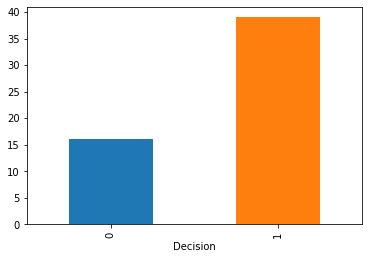

In [68]:
Scoring.groupby('Decision').size().plot(kind='bar')

In [69]:
Scoring.describe()

,Decision,Proba_0,Proba_1
count,55.00,55.00,55.00
mean,0.71,0.33,0.67
std,0.46,0.23,0.23
min,0.00,0.05,0.28
25%,0.00,0.08,0.49
50%,1.00,0.39,0.61
75%,1.00,0.51,0.92
max,1.00,0.72,0.95


### 4.4 Exportation des scores dans un fichier CSV

In [70]:
import time
datedujour = time.strftime("%Y-%m-%d-%H%M%S")

In [71]:
# Export des scores dans un fichier CSV
Scoring.to_csv(r'Exports/Scores_Titanic_'+datedujour+'.csv')

In [72]:
# Visualisation des fichiers CSV exportés
%ls Exports/*.csv -ls

3 -rwxrwxrwx 1 root root 2394 Jun 15 08:06 Exports/Scores_Titanic_2020-06-15-075905.csv*
3 -rwxrwxrwx 1 root root 2394 Jun 23 12:11 Exports/Scores_Titanic_2020-06-23-121107.csv*
3 -rwxrwxrwx 1 root root 2405 Sep 30 15:44 Exports/Scores_Titanic_2020-09-30-154445.csv*


> End of notebook